# 1. Generate images set out of original lunar DEM tile (60 m/pix)
This notebook is identical to the SLDEM60_sets notebook, only here we use the original 16-bit tile instead of the reduced 8-bit tile. We first create the frames, resizes and then reduce to 8-bit, keeping more information within each frame. 

Initialize workspace: 

In [14]:
import sys
sys.path.append('../')
from PIL import Image
import time
Image.MAX_IMAGE_PIXELS = 353894500
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import input_data_gen as igen
import utils.processing as proc
import h5py
import utils.maplot
np.random.seed(42)

data_path='../../data/'

JPEG2000 (23040, 15360) I;16
160.64004921913147
Number of unique values: 16710


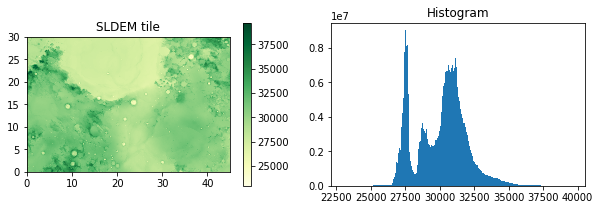

In [15]:
# Read source image.
img = Image.open(data_path + "/sldem2015_512_00n_30n_000_045.jp2")
print(img.format, img.size, img.mode)
# [Min long, max long, min lat, max lat] dimensions of source image.
source_cdim = [0., 45., 0., 30.]
start_time = time.time()
fig = plt.figure(figsize=[10, 3])
plt.subplot(1,2,1)
plt.title('SLDEM tile')
plt.imshow(img, extent=source_cdim, aspect="equal", cmap="YlGn")
plt.colorbar()
plt.subplot(1,2,2)
img_arr = np.concatenate(np.asarray(img))
plt.hist(img_arr, 256);
plt.title('Histogram')
print(time.time() - start_time)
print('Number of unique values: {}'.format(len(np.unique(img_arr))))

In [16]:
np.random.seed(42)
# Import crater catalogs (stored under /catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc="../catalogues/LROCCraters.csv",
                                  filehead="../catalogues/HeadCraters.csv")

fn = '../data/test_SLDEM60_16bit2'
sub_cdim = source_cdim

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])
craters.tail()
start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=1, rawlen_range=[256*2, 2000*2], seed=42, verbose=True)

print("Time elapsed: {0:.1f} sec".format(time.time() - start_time))

FileNotFoundError: File b'catalogues/HeadCraters.csv' does not exist

In [22]:
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc="../catalogues/LROCCraters.csv",
                                  filehead="../catalogues/HeadCraters.csv")
print(craters.tail())
craters_new = igen.ReadRobbinsCraterCSV(filename="../catalogues/RobbinsLunarCraters.csv")
craters_new.tail()


       Diameter (km)        Lat       Long
24515      32.903893  86.691596  70.778013
24516      66.602308  86.967911 -20.230297
24517      20.426893  87.958268 -51.135700
24518      78.592181  88.660842  24.528101
24519      31.006883  89.324090  78.572550


TypeError: unorderable types: str() > int()

Produce another set based on the Robbins catalog: 

In [4]:
# Read the Robbins dataset (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="catalogues/RobbinsLunarCraters.csv")
np.random.seed(42)
fn = '../data/test_SLDEM60_Robbins_16bit'
sub_cdim = source_cdim

# Sample subset of image.  Co-opt igen.ResampleCraters to remove all
# craters beyond cdim (either sub or source).
if sub_cdim != source_cdim:
    img = igen.InitialImageCut(img, source_cdim, sub_cdim)
craters = igen.ResampleCraters(craters, sub_cdim, img.size[1])
craters.tail()

start_time = time.time()

# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256*2, 2000*2], seed=42, verbose=True)

print("Time elapsed: {0:.1f} sec".format(time.time() - start_time))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
Time elapsed: 2.0 sec


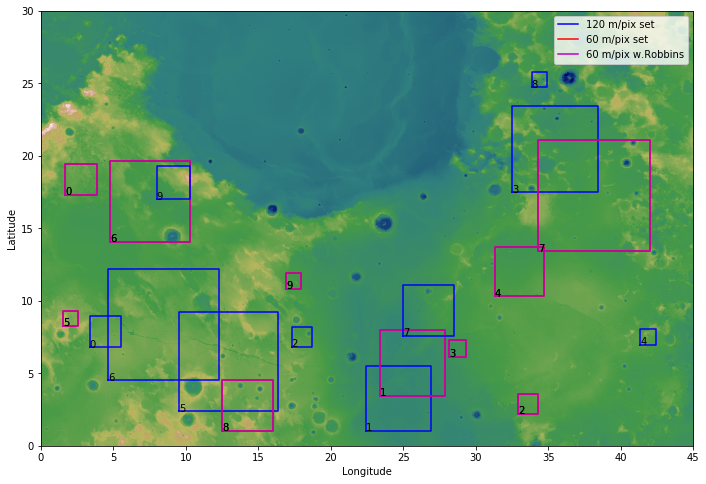

In [5]:
fn = '../data/test_SLDEM60_16bit'
gen_imgs_60 = h5py.File(fn + '_images.hdf5', 'r')
fn = '../data/test_SLDEM120'
gen_imgs_120 = h5py.File(fn + '_images.hdf5', 'r')
fn = '../data/test_SLDEM60_Robbins_16bit'
gen_imgs_60_r = h5py.File(fn + '_images.hdf5', 'r')

# See frames of the set we produced: 
subset_list = np.arange(10)
fig = plt.figure(figsize=[16, 8])
dem_map = plt.imshow(img, extent=sub_cdim, aspect="equal", cmap="gist_earth")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
for i in subset_list:
  llon,rlon,llat,ulat=gen_imgs_120['longlat_bounds']['img_{:02d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
  plt.text(llon,llat,str(i), color='k')
  
  llon,rlon,llat,ulat=gen_imgs_60['longlat_bounds']['img_{:02d}'.format(i)][...]
  h2,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='k')

  llon,rlon,llat,ulat=gen_imgs_60_r['longlat_bounds']['img_{:02d}'.format(i)][...]
  h3,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'m')
  plt.text(llon,llat,str(i), color='k')

plt.legend([h1,h2,h3],['120 m/pix set','60 m/pix set','60 m/pix w.Robbins']);


In [6]:
# how many unique values in each frame? 
UV60=[len(np.unique(gen_imgs_60['input_images'][i].flatten())) for i in range(10)]
UV120=[len(np.unique(gen_imgs_120['input_images'][i].flatten())) for i in range(10)]
print('For the 60 set {}±{:.1f} unique values'.format(np.mean(UV60),np.std(UV60)))
print('For the 120 set {}±{:.1f} unique values'.format(np.mean(UV120),np.std(UV120)))

For the 60 set 255.0±0.0 unique values
For the 120 set 37.7±13.9 unique values


Compare these new sets of SLDEM60 to the set we made from SLDEM120: 

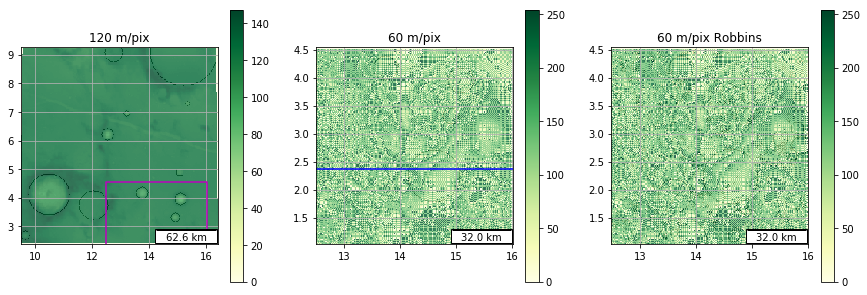

In [7]:
im_num_120=5
im_num_60=8
fig = plt.figure(figsize=[15, 5])

ax=plt.subplot(1,3,1);
utils.maplot.plot_map_w_scalebar2(ax,gen_imgs_120,im_num_120,colorbar=True)
l,r=plt.xlim(); u,d=plt.ylim()
llon,rlon,llat,ulat=gen_imgs_60['longlat_bounds']['img_{:02d}'.format(im_num_60)][...]
plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'m')
plt.xlim((l,r)); plt.ylim((u,d))
plt.title('120 m/pix')

ax2=plt.subplot(1,3,2);
utils.maplot.plot_map_w_scalebar2(ax2,gen_imgs_60,im_num_60,colorbar=True)
l,r=plt.xlim(); u,d=plt.ylim()
llon,rlon,llat,ulat=gen_imgs_120['longlat_bounds']['img_{:02d}'.format(im_num_120)][...]
plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
plt.xlim((l,r)); plt.ylim((u,d))
plt.title('60 m/pix')

ax3=plt.subplot(1,3,3)
utils.maplot.plot_map_w_scalebar2(ax3,gen_imgs_60_r,im_num_60,colorbar=True);
plt.title('60 m/pix Robbins');

# 2. Test model on frames from new DEM

In [8]:
import keras
keras.__version__

Using TensorFlow backend.


'1.2.2'

In [9]:
from keras.models import load_model
import sys
deepmoon_path='../DeepCrater'
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Use the commented out line for Keras 2.0+
# model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(data_path + '/model_keras1.2.2.h5')

def predict_and_show(gen_imgs, im_num, craters):
    sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
    proc.preprocess(sample_data)
    sd_input_images = sample_data['imgs'][0]
    sd_target_masks = sample_data['imgs'][1]
    pred = model.predict(sd_input_images[im_num:im_num + 1])
    # Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
    extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=1.)
    fig = plt.figure(figsize=[18, 6])
    [ax1, ax2, ax3] = fig.subplots(1, 3)
    ax1.imshow(sd_input_images[im_num].squeeze(), origin='upper', cmap='YlGn')
    ax1.imshow(1-sd_target_masks[im_num].squeeze(), origin='upper', cmap='Greys_r', alpha=0.3)
    ax2.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
    ax3.imshow(sd_input_images[im_num].squeeze(), origin='upper', cmap="YlGn")
    for x, y, r in extracted_rings:
        circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.9)
        ax3.add_artist(circle)
    ax1.set_title('DEM + Ground-Truth')
    ax2.set_title('CNN Predictions')
    ax3.set_title('Post-CNN Craters')
    plt.show()
    sub_cdim=gen_imgs['longlat_bounds']['img_{:02d}'.format(im_num)][...]
    import pandas as pd
    df1=pd.DataFrame(data=extracted_rings, columns=['x','y','r'])
    df1['catalog']='DeepCrater'
    df1['Diameter (km)']=np.round(df1['r']*2*(sub_cdim[1]-sub_cdim[0])/256*30).astype(int) #D=2*radius_pix*deg/pix*km/deg
    df2 = igen.ResampleCraters(craters, sub_cdim, 256)
    df2['Diameter (km)']=df2['Diameter (km)'].round().astype(int)
    df2['catalog']='Robbins'
    c=pd.get_dummies(pd.concat([df1[['Diameter (km)','catalog']],df2[['Diameter (km)','catalog']]])).astype(int)
    c=c.pivot_table(index='Diameter (km)',aggfunc=sum, margins=True).astype(int)
    print(c)

/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


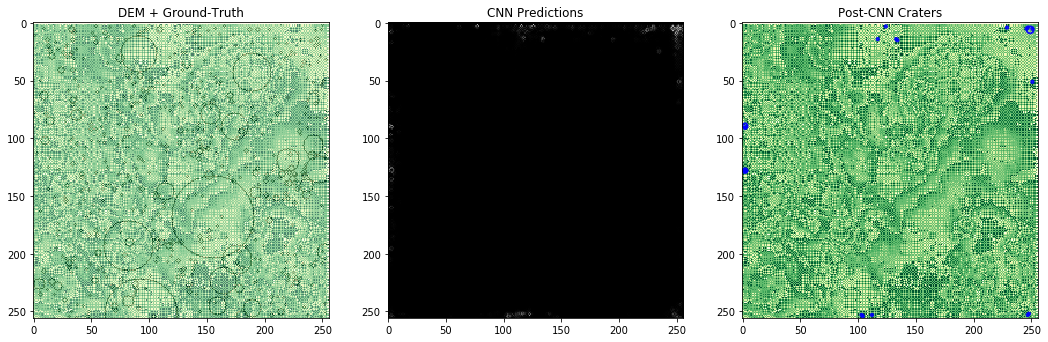

               catalog_DeepCrater  catalog_Robbins
Diameter (km)                                     
1                              18              461
2                               3               78
3                               0               22
4                               0                5
5                               0                2
6                               0                1
7                               0                5
8                               0                1
10                              0                3
11                              0                1
13                              0                1
14                              0                1
18                              0                1
27                              0                1
30                              0                1
All                            21              584


In [10]:
predict_and_show(gen_imgs_60_r, im_num_60, craters)

# 3. Test model only on small frames of SLDEM60

In [11]:
np.random.seed(42)
# Import crater catalogs (stored under /catalogues)
craters = igen.ReadRobbinsCraterCSV(filename="catalogues/RobbinsLunarCraters.csv")
fn = '../data/test_SLDEM60_small'
sub_cdim = source_cdim
# Generate input images: 
igen.GenDataset(img, craters, fn, 
                 cdim=sub_cdim, amt=10, rawlen_range=[256, 256], seed=42, verbose=True)

gen_imgs_60_small = h5py.File(fn + '_images.hdf5', 'r')
# how many unique values in each frame? 
UV60=[len(np.unique(gen_imgs_60_small['input_images'][i].flatten())) for i in range(10)]
print('For the 60_small set there are mean of {}±{:.1f} unique values'.format(np.mean(UV60),np.std(UV60)))

Generating img_00
Generating img_01
Generating img_02
Generating img_03
Generating img_04
Generating img_05
Generating img_06
Generating img_07
Generating img_08
Generating img_09
For the 60_small set there are mean of 255.0±0.0 unique values


/home/grosman/projectDC/DeepCrater/technical/deep_crater_env/lib/python3.5/site-packages/skimage/feature/template.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return response[slices]


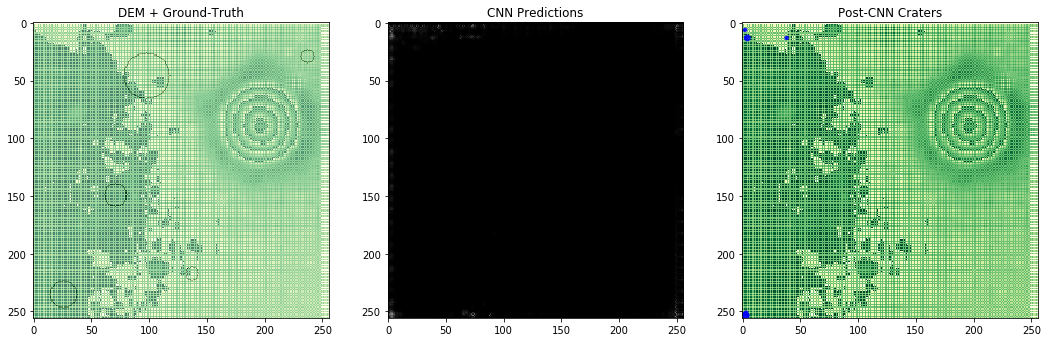

               catalog_DeepCrater  catalog_Robbins
Diameter (km)                                     
0                               9                0
1                               0                4
2                               0                1
All                             9                5


In [12]:
predict_and_show(gen_imgs_60_small, 2, craters)